<a href="https://colab.research.google.com/github/Saria-Alashry/Alashry/blob/master/week8_sequence_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="rtl" style="text-align: right; font-size: 28px; font-weight: bold; background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); padding: 20px; border-radius: 10px; margin-bottom: 20px;">

# Week 8: Sequence Models (RNN, LSTM, GRU, BiRNN)

النهاردة هنطبقها على Text Classification بإذن الله!

</div>

## Overview

**Instructor:** Dr. Mahmoud Eid (m.eid@fci-cu.edu.eg)

**Estimated Time:** 3-4 hours

**What You'll Learn:**

**Part 1: Many-to-Many Sequence Classification (Food Entity Recognition)**

- Word-level classification (is each word food or not?)
- Tokenization and pre-trained word embeddings (GloVe)
- We will work with Vanilla RNN → GRU → LSTM → BiLSTM

**Part 2: Many-to-One Sequence Classification (Spam classification, PRACTICE)**


**Prerequisites:** PyTorch basics (Week 5+), Knowledge about text (Lecture 13 and Lecture 14)

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter, defaultdict
from datasets import load_dataset
import random
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('dark_background')
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.0+cpu


---

<div dir="rtl" style="text-align: right; font-size: 22px; font-weight: bold; background-color: #1a1a2e; padding: 15px; border-radius: 10px;">

# Part 1: Many-to-Many (Food Entity Recognition)

</div>

**Task:** Given a sentence, classify **each word** as food (1) or not food (0)

**Example:**

- Sentence: `"I love eating pizza for dinner"`
- Labels: `[0, 0, 0, 1, 0, 0]` (only "pizza" is food)

This is **Named Entity Recognition (NER)** for food items!


## Step 1: Generate Food Entity Dataset

We'll create 1200 diverse sentences with 102 unique food items to ensure models **learn patterns** (not just memorize)!


In [2]:
# Food vocabulary (102 unique items across 9 categories)
food_items = {
    'proteins': ['chicken', 'beef', 'fish', 'salmon', 'tuna', 'turkey', 'lamb',
                 'shrimp', 'tofu', 'eggs', 'duck', 'crab', 'lobster'],
    'vegetables': ['carrot', 'broccoli', 'spinach', 'tomato', 'onion', 'garlic', 'pepper',
                   'lettuce', 'cucumber', 'potato', 'mushroom', 'celery', 'kale', 'zucchini',
                   'eggplant', 'avocado', 'beans', 'peas'],
    'fruits': ['apple', 'banana', 'orange', 'strawberry', 'blueberry', 'mango', 'pineapple',
               'grape', 'watermelon', 'lemon', 'lime', 'peach', 'cherry', 'kiwi', 'berries'],
    'grains': ['rice', 'pasta', 'bread', 'quinoa', 'oats', 'noodles', 'tortilla', 'bagel',
               'cereal', 'couscous', 'barley', 'crackers'],
    'dairy': ['milk', 'cheese', 'yogurt', 'butter', 'cream'],
    'beverages': ['coffee', 'tea', 'juice', 'water', 'soda', 'wine', 'beer', 'smoothie',
                  'latte', 'lemonade'],
    'dishes': ['pizza', 'burger', 'salad', 'soup', 'sandwich', 'curry', 'steak', 'sushi',
               'taco', 'burrito', 'ramen', 'lasagna', 'pie', 'omelet', 'pancakes'],
    'spices': ['salt', 'pepper', 'cinnamon', 'vanilla', 'oregano', 'basil', 'thyme', 'cumin',
               'paprika', 'ginger'],
    'sweets': ['chocolate', 'cake', 'cookie', 'candy', 'donut', 'brownie', 'muffin', 'pudding',
               'syrup', 'honey'],
}

all_foods = set([item for category in food_items.values() for item in category])
print(f"Total unique food items: {len(all_foods)}")
print(f"Sample foods: {list(all_foods)[:15]}")

Total unique food items: 107
Sample foods: ['kale', 'ramen', 'peach', 'rice', 'cucumber', 'pizza', 'onion', 'quinoa', 'butter', 'soda', 'vanilla', 'sandwich', 'lamb', 'fish', 'pudding']


In [3]:
# Sentence templates with diverse structures
templates = [
    "I love eating {food} for {meal}",
    "The restaurant serves delicious {food}",
    "She ordered {food} and {food} for dinner",
    "My favorite breakfast is {food} with {food}",
    "He drinks {beverage} every morning",
    "The chef prepared {food} with {food}",
    "Add some {spice} to the {food}",
    "I bought fresh {food} from the market",
    "The {food} tastes amazing with {spice}",
    "She prefers {beverage} over {beverage}",
    "The menu includes {food} and {food}",
    "We shared a large {food} last night",
    "Bake the {food} for thirty minutes",
    "Season with {spice} and {spice} generously",
    "Grill the {food} on high heat",
    "I need to buy {food} and {food}",
    "The bakery has fresh {food} daily",
    "My lunch includes {food} and chips",
    "The kids want {food} for lunch",
    "Dinner tonight is {food} with {food}",
    "Mix {food} and {spice} in a bowl",
    "The {food} was perfectly cooked",
    "She enjoys {beverage} with her meal",
    "The store sells organic {food}",
    "Top it with some {food}",
]

meals = ['breakfast', 'lunch', 'dinner', 'snack', 'brunch']


def generate_food_sentence():
    """Generate a random sentence with food entities"""
    template = random.choice(templates)
    sentence = template

    if '{meal}' in sentence:
        sentence = sentence.replace('{meal}', random.choice(meals))

    while '{food}' in sentence:
        category = random.choice(list(food_items.keys()))
        sentence = sentence.replace('{food}', random.choice(food_items[category]), 1)

    while '{beverage}' in sentence:
        sentence = sentence.replace('{beverage}', random.choice(food_items['beverages']), 1)

    while '{spice}' in sentence:
        sentence = sentence.replace('{spice}', random.choice(food_items['spices']), 1)

    # word-level labels
    words = sentence.lower().split()
    labels = [1 if word in all_foods else 0 for word in words]

    return words, labels


# Generate 1200 sentences
random.seed(42)
all_sentences = []
all_labels = []

for i in range(1200):
    words, labels = generate_food_sentence()
    all_sentences.append(words)
    all_labels.append(labels)

# note here how we are adding some samples that express a different meaning than food
# so that the models understand from the context that this is not food
challenging_context_cases = [
    # Animals (not food context)
    (["the", "chicken", "crossed", "the", "road"], [0, 0, 0, 0, 0]),
    (["i", "saw", "a", "turkey", "in", "the", "forest"], [0, 0, 0, 0, 0, 0, 0]),
    (["the", "fish", "are", "swimming", "in", "the", "lake"], [0, 0, 0, 0, 0, 0, 0]),
    (["she", "bought", "a", "duck", "for", "the", "pond"], [0, 0, 0, 0, 0, 0, 0]),
    (["the", "lamb", "is", "grazing", "in", "the", "field"], [0, 0, 0, 0, 0, 0, 0]),

    # Non-food compound words
    (["the", "coffee", "table", "is", "made", "of", "wood"], [0, 0, 0, 0, 0, 0, 0]),
    (["she", "opened", "a", "juice", "bar", "downtown"], [0, 0, 0, 0, 0, 0]),
    (["the", "pepper", "spray", "was", "very", "effective"], [0, 0, 0, 0, 0, 0]),
    (["he", "wore", "a", "chocolate", "brown", "jacket"], [0, 0, 0, 0, 0, 0]),
    (["the", "bread", "basket", "arrived", "empty"], [0, 0, 0, 0, 0]),
    (["the", "apple", "tree", "is", "blooming"], [0, 0, 0, 0, 0]),
    (["she", "has", "strawberry", "blonde", "hair"], [0, 0, 0, 0, 0]),
    (["the", "milk", "bottle", "is", "in", "recycling"], [0, 0, 0, 0, 0, 0]),
    (["the", "cheese", "grater", "is", "sharp"], [0, 0, 0, 0, 0]),

    # Food context (these are food)
    (["i", "love", "eating", "grilled", "chicken", "breast"], [0, 0, 0, 0, 1, 1]),
    (["she", "ordered", "fresh", "fish", "for", "dinner"], [0, 0, 0, 1, 0, 0]),
    (["the", "roasted", "duck", "was", "delicious"], [0, 0, 1, 0, 0]),
    (["i", "cooked", "lamb", "chops", "yesterday"], [0, 0, 1, 0, 0]),
    (["he", "drinks", "coffee", "every", "morning"], [0, 0, 1, 0, 0]),
    (["pour", "orange", "juice", "into", "the", "glass"], [0, 0, 1, 0, 0, 0]),
    (["she", "spread", "strawberry", "jam", "on", "toast"], [0, 0, 1, 1, 0, 1]),
    (["the", "apple", "pie", "smells", "amazing"], [0, 1, 1, 0, 0]),
    (["he", "bought", "fresh", "milk", "today"], [0, 0, 0, 1, 0]),
    (["grate", "some", "cheese", "on", "top"], [0, 0, 1, 0, 0]),
]

# adding challenging cases many times to training (so model learns them well)
# Repeat 10 times to emphasize these patterns
for _ in range(10):
    for sentence, labels in challenging_context_cases:
        all_sentences.append(sentence)
        all_labels.append(labels)

# Shuffle all data
combined = list(zip(all_sentences, all_labels))  # combined will be a list [ (sentence1, label1), (sentence2, label2), (sentence3, label3), ...]
# zip(sentences, labels) -> pairs row by row.
random.shuffle(combined)
all_sentences, all_labels = zip(*combined)  # we un-pack with * then re-zip across columns
# zip(*combined) -> transposes the list of pairs back into two separate lists/tuples (columns).
all_sentences = list(all_sentences)
all_labels = list(all_labels)

# Split: 80% train, 10% validation, 10% test
split_idx1 = int(0.8 * len(all_sentences))
split_idx2 = int(0.9 * len(all_sentences))

train_sentences = all_sentences[:split_idx1]
train_labels = all_labels[:split_idx1]
val_sentences = all_sentences[split_idx1:split_idx2]
val_labels = all_labels[split_idx1:split_idx2]
test_sentences = all_sentences[split_idx2:]
test_labels = all_labels[split_idx2:]

print(f"Generated {len(all_sentences)} total sentences (includes challenging cases repeated 10x for training)")
print(f"Train: {len(train_sentences)}, Validation: {len(val_sentences)}, Test: {len(test_sentences)}")
print(f"\n{'='*60}")
print("Sample challenging sentences (now part of training!):")
print("\n1. the chicken crossed the road")
print("   Labels: [0,0,0,0,0] (chicken = animal, NOT food)")
print("\n2. i love eating grilled chicken breast")
print("   Labels: [0,0,0,0,1,1] (chicken = food in this context)")
print("\n3. the coffee table is made of wood")
print("   Labels: [0,0,0,0,0,0,0] (coffee table = furniture)")
print("\n4. he drinks coffee every morning")
print("   Labels: [0,0,1,0,0] (coffee = beverage)")

Generated 1440 total sentences (includes challenging cases repeated 10x for training)
Train: 1152, Validation: 144, Test: 144

Sample challenging sentences (now part of training!):

1. the chicken crossed the road
   Labels: [0,0,0,0,0] (chicken = animal, NOT food)

2. i love eating grilled chicken breast
   Labels: [0,0,0,0,1,1] (chicken = food in this context)

3. the coffee table is made of wood
   Labels: [0,0,0,0,0,0,0] (coffee table = furniture)

4. he drinks coffee every morning
   Labels: [0,0,1,0,0] (coffee = beverage)


---

## Step 2: Build Vocabulary and Load Pre-trained Embeddings

We'll use **GloVe** (Global Vectors) embeddings trained on billions of words. This gives our models semantic understanding!


In [4]:
# Build vocabulary from training data
vocab = {'<PAD>': 0, '<UNK>': 1}
word_counts = Counter()

for sentence in train_sentences:
    word_counts.update(sentence)

# Add words that appear at least twice
for word, count in word_counts.items():
    if count >= 2 and word not in vocab:
        vocab[word] = len(vocab)

print(f"Vocabulary size: {len(vocab)}")
print(f"Sample vocab: {list(vocab.items())[:10]}")

# Reverse vocabulary (id -> word)
id2word = {idx: word for word, idx in vocab.items()}

Vocabulary size: 233
Sample vocab: [('<PAD>', 0), ('<UNK>', 1), ('the', 2), ('bakery', 3), ('has', 4), ('fresh', 5), ('brownie', 6), ('daily', 7), ('she', 8), ('prefers', 9)]


In [5]:
# note in here how i didn't give you the file but i uploaded it to my google drive
# so that you can download them to your colab machine
# glove_path = 'https://drive.google.com/file/d/1WTbdKo7sNTfvRim2Sxm_aSNn2sCibe1q/view?usp=sharing'
import gdown

# Google Drive file ID from my link
file_id = "1WTbdKo7sNTfvRim2Sxm_aSNn2sCibe1q"
url = f"https://drive.google.com/uc?id={file_id}"

output = "glove_vectors.txt"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1WTbdKo7sNTfvRim2Sxm_aSNn2sCibe1q
From (redirected): https://drive.google.com/uc?id=1WTbdKo7sNTfvRim2Sxm_aSNn2sCibe1q&confirm=t&uuid=f1724a8b-c6db-462a-9bf2-ba4113e34609
To: /content/glove_vectors.txt
100%|██████████| 1.68G/1.68G [00:15<00:00, 112MB/s]


'glove_vectors.txt'

In [6]:
# Load pre-trained GloVe embeddings
# GloVe (Global Vectors) trained on Wikipedia + Gigaword corpus
EMBEDDING_DIM = 100

print("Loading GloVe embeddings...")


#glove_path = 'glove.2024.wikigiga.100d\wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt'
glove_path = 'glove_vectors.txt'
# Load GloVe vectors
glove_vectors = {}
skipped = 0

with open(glove_path, 'r', encoding='utf-8') as f:
    for line_num, line in enumerate(f):
        try:
            values = line.rstrip().split(' ')
            word = values[0]
            vector = np.array(values[1:], dtype='float32')

            # Only add if vector has correct dimension
            if len(vector) == EMBEDDING_DIM:
                glove_vectors[word] = vector
            else:
                skipped += 1
        except (ValueError, IndexError):
            skipped += 1
            continue

        if (line_num + 1) % 100000 == 0:
            print(f"  Processed {line_num + 1:,} lines...")

print(f"\nLoaded {len(glove_vectors):,} GloVe vectors")
if skipped > 0:
    print(f"Skipped {skipped:,} malformed lines")

Loading GloVe embeddings...
  Processed 100,000 lines...
  Processed 200,000 lines...
  Processed 300,000 lines...
  Processed 400,000 lines...
  Processed 500,000 lines...
  Processed 600,000 lines...
  Processed 700,000 lines...
  Processed 800,000 lines...
  Processed 900,000 lines...
  Processed 1,000,000 lines...
  Processed 1,100,000 lines...
  Processed 1,200,000 lines...

Loaded 1,291,147 GloVe vectors


In [7]:
# Create embedding matrix for our vocabulary
embedding_matrix = np.random.randn(len(vocab), EMBEDDING_DIM).astype('float32') * 0.01

# Special tokens
embedding_matrix[vocab['<PAD>']] = np.zeros(EMBEDDING_DIM)

# Fill in GloVe vectors for words in our vocabulary
found_count = 0
for word, idx in vocab.items():
    if word in glove_vectors:
        embedding_matrix[idx] = glove_vectors[word]
        found_count += 1

print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Found pre-trained vectors for {found_count}/{len(vocab)} words ({100*found_count/len(vocab):.1f}%)")


Embedding matrix shape: (233, 100)
Found pre-trained vectors for 231/233 words (99.1%)


---

## Step 3: Create PyTorch Dataset and DataLoader

We'll use **DataLoader** to efficiently batch and sample data (saves memory!).


In [8]:
class FoodNERDataset(Dataset):
    """Dataset for food entity recognition"""

    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        # Convert words to indices
        word_ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in self.sentences[idx]]
        # if the word is not in vocabulary it returns the ID of the special token <UNK>
        labels = self.labels[idx]

        return torch.tensor(word_ids, dtype=torch.long), torch.tensor(labels, dtype=torch.long)


def collate_fn(batch):
    """Collate function to pad sequences in a batch together
    we pad sequences to equal length so they can be batched into a tensor
    also note: for labels, we use padding_value=-1 so the loss function ignores
    those positions — so the model doesn't learn from <PAD> tokens"""
    sentences, labels = zip(*batch)

    # Get lengths before padding
    lengths = torch.tensor([len(s) for s in sentences])

    # Pad sequences
    padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=vocab['<PAD>'])
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-1)  # -1 will be ignored in loss

    return padded_sentences, padded_labels, lengths


# Create datasets
train_dataset = FoodNERDataset(train_sentences, train_labels, vocab)
test_dataset = FoodNERDataset(test_sentences, test_labels, vocab)

# Create dataloaders (batch_size=32 for memory efficiency)
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"\nSample batch:")
sample_batch = next(iter(train_loader))
print(f"  Sentences shape: {sample_batch[0].shape}")  # (batch_size, max_seq_len)
print(f"  Labels shape: {sample_batch[1].shape}")
print(f"  Lengths: {sample_batch[2][:5]}")

Train batches: 36
Test batches: 5

Sample batch:
  Sentences shape: torch.Size([32, 7])
  Labels shape: torch.Size([32, 7])
  Lengths: tensor([6, 5, 7, 7, 5])


---

<div dir="rtl" style="text-align: right; font-size: 22px; font-weight: bold; background-color: #1a1a2e; padding: 15px; border-radius: 10px;">

## Step 4: Implement the sequence Models

</div>

We'll implement and compare:

1. **Vanilla RNN** - Simple recurrent network
2. **GRU** - Gated Recurrent Unit (addresses vanishing gradients)
3. **LSTM** - Long Short-Term Memory (better at long-term dependencies)
4. **BiLSTM** - Bidirectional LSTM (processes text forward AND backward)


In [9]:
# Vanilla RNN Model
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)
        output, _ = self.rnn(embedded)  # (batch, seq_len, hidden)
        predictions = self.fc(output)  # (batch, seq_len, output_dim)
        return predictions

# GRU Model
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        predictions = self.fc(output)
        return predictions

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        predictions = self.fc(output)
        return predictions

# BiLSTM Model (processes forward AND backward)
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)  # (batch, seq_len, hidden*2)
        predictions = self.fc(output)
        return predictions


print("  1. Vanilla RNN")
print("  2. GRU - Better gradient flow")
print("  3. LSTM - Handles long-term dependencies")
print("  4. BiLSTM - Sees context from both directions")

  1. Vanilla RNN
  2. GRU - Better gradient flow
  3. LSTM - Handles long-term dependencies
  4. BiLSTM - Sees context from both directions


In [10]:
def train_model(model, train_loader, epochs=5, lr=0.001):
    """Train a sequence model"""
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch_idx, (sentences, labels, lengths) in enumerate(train_loader):
            sentences, labels = sentences.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(sentences)  # (batch, seq_len, 2)

            # Reshape for loss computation
            predictions = predictions.view(-1, 2)  # (batch*seq_len, 2) .. -1 means the number is not specified
            # so that would take the first two dimensions as the new first dimension and the second dimension is 2 (food vs. not food)
            labels = labels.view(-1)  # (batch*seq_len,)

            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return losses


print("Training function ready!")

Training function ready!


In [11]:
def evaluate_model(model, test_loader):
    """Evaluate model and return accuracy"""
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sentences, labels, lengths in test_loader:
            sentences = sentences.to(device)
            predictions = model(sentences)
            predictions = torch.argmax(predictions, dim=2)  # (batch, seq_len)

            # Collect predictions and labels (ignore padding)
            for i in range(len(sentences)):
                length = lengths[i].item()
                all_preds.extend(predictions[i, :length].cpu().numpy())
                all_labels.extend(labels[i, :length].numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


print("Evaluation function ready!")

Evaluation function ready!


---

## Step 5: Train and Compare All Models

Let's train all 4 models and see which performs best!


In [12]:
# Hyperparameters
HIDDEN_DIM = 128
OUTPUT_DIM = 2  # Binary classification (food vs not-food)
EPOCHS = 10
LR = 0.001

results = {}

# 1. Vanilla RNN
print("="*60)
print("Training Vanilla RNN...")
print("="*60)
rnn_model = VanillaRNN(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_matrix)
rnn_losses = train_model(rnn_model, train_loader, epochs=EPOCHS, lr=LR)
rnn_acc = evaluate_model(rnn_model, test_loader)
results['Vanilla RNN'] = {'losses': rnn_losses, 'accuracy': rnn_acc}
print(f"\nVanilla RNN Test Accuracy: {rnn_acc:.4f}\n")

# 2. GRU
print("="*60)
print("Training GRU...")
print("="*60)
gru_model = GRUModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_matrix)
gru_losses = train_model(gru_model, train_loader, epochs=EPOCHS, lr=LR)
gru_acc = evaluate_model(gru_model, test_loader)
results['GRU'] = {'losses': gru_losses, 'accuracy': gru_acc}
print(f"\n✓ GRU Test Accuracy: {gru_acc:.4f}\n")

# 3. LSTM
print("="*60)
print("Training LSTM...")
print("="*60)
lstm_model = LSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_matrix)
lstm_losses = train_model(lstm_model, train_loader, epochs=EPOCHS, lr=LR)
lstm_acc = evaluate_model(lstm_model, test_loader)
results['LSTM'] = {'losses': lstm_losses, 'accuracy': lstm_acc}
print(f"\n✓ LSTM Test Accuracy: {lstm_acc:.4f}\n")

# 4. BiLSTM
print("="*60)
print("Training BiLSTM (Bidirectional)...")
print("="*60)
bilstm_model = BiLSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_matrix)
bilstm_losses = train_model(bilstm_model, train_loader, epochs=EPOCHS, lr=LR)
bilstm_acc = evaluate_model(bilstm_model, test_loader)
results['BiLSTM'] = {'losses': bilstm_losses, 'accuracy': bilstm_acc}
print(f"\n✓ BiLSTM Test Accuracy: {bilstm_acc:.4f}\n")

Training Vanilla RNN...
Epoch 1/10, Loss: 0.2148
Epoch 2/10, Loss: 0.0409
Epoch 3/10, Loss: 0.0203
Epoch 4/10, Loss: 0.0129
Epoch 5/10, Loss: 0.0107
Epoch 6/10, Loss: 0.0091
Epoch 7/10, Loss: 0.0072
Epoch 8/10, Loss: 0.0070
Epoch 9/10, Loss: 0.0093
Epoch 10/10, Loss: 0.0077

Vanilla RNN Test Accuracy: 0.9965

Training GRU...
Epoch 1/10, Loss: 0.3103
Epoch 2/10, Loss: 0.0709
Epoch 3/10, Loss: 0.0231
Epoch 4/10, Loss: 0.0126
Epoch 5/10, Loss: 0.0095
Epoch 6/10, Loss: 0.0082
Epoch 7/10, Loss: 0.0072
Epoch 8/10, Loss: 0.0070
Epoch 9/10, Loss: 0.0063
Epoch 10/10, Loss: 0.0068

✓ GRU Test Accuracy: 0.9965

Training LSTM...
Epoch 1/10, Loss: 0.4076
Epoch 2/10, Loss: 0.0827
Epoch 3/10, Loss: 0.0227
Epoch 4/10, Loss: 0.0128
Epoch 5/10, Loss: 0.0093
Epoch 6/10, Loss: 0.0081
Epoch 7/10, Loss: 0.0069
Epoch 8/10, Loss: 0.0071
Epoch 9/10, Loss: 0.0068
Epoch 10/10, Loss: 0.0059

✓ LSTM Test Accuracy: 0.9977

Training BiLSTM (Bidirectional)...
Epoch 1/10, Loss: 0.3607
Epoch 2/10, Loss: 0.0511
Epoch 3/

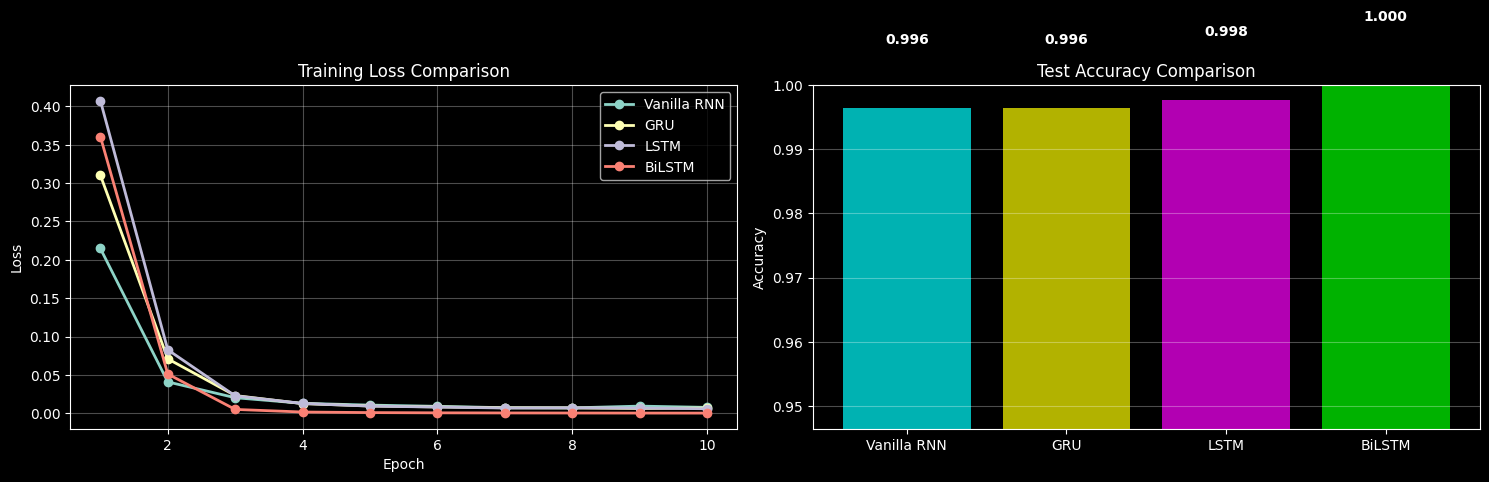

RESULTS SUMMARY
Vanilla RNN     Accuracy: 0.9965
GRU             Accuracy: 0.9965
LSTM            Accuracy: 0.9977
BiLSTM          Accuracy: 1.0000


In [13]:
# Compare all models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for name, data in results.items():
    ax1.plot(range(1, EPOCHS+1), data['losses'], marker='o', label=name, linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison')
ax1.legend()
ax1.grid(alpha=0.3)

models = list(results.keys())
accuracies = [results[m]['accuracy'] for m in models]
colors = ['cyan', 'yellow', 'magenta', 'lime']
ax2.bar(models, accuracies, color=colors, alpha=0.7)
ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy Comparison')
ax2.set_ylim([min(accuracies) - 0.05, 1.0])
ax2.grid(alpha=0.3, axis='y')

for i, v in enumerate(accuracies):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("="*60)
print("RESULTS SUMMARY")
print("="*60)
for name, data in results.items():
    print(f"{name:15s} Accuracy: {data['accuracy']:.4f}")
print("="*60)

---

## Now let's test the best model (BiLSTM) with your own sentences!


In [14]:
def predict_food_entities(sentence, model, vocab):
    """
    Predict food entities in a custom sentence.

    Args:
        sentence: String sentence to analyze
        model: Trained BiLSTM model
        vocab: Vocabulary dictionary

    Returns:
        List of (word, is_food, confidence) tuples
    """
    model.eval()

    # Tokenize
    words = sentence.lower().split()
    word_ids = [vocab.get(word, vocab['<UNK>']) for word in words]

    # Convert to tensor
    input_tensor = torch.tensor([word_ids], dtype=torch.long).to(device)

    # Predict
    with torch.no_grad():
        predictions = model(input_tensor)  # (1, seq_len, 2)
        probabilities = torch.softmax(predictions[0], dim=1)  # (seq_len, 2)
        predicted_labels = torch.argmax(probabilities, dim=1).cpu().numpy()
        confidences = probabilities[:, 1].cpu().numpy()  # Confidence for "food" class

    # Format results
    results = []
    for word, label, conf in zip(words, predicted_labels, confidences):
        results.append((word, bool(label), float(conf)))

    return results


def display_food_predictions(sentence, results):
    """Display predictions in a nice format"""
    print(f"\nSentence: {sentence}")
    print("="*60)
    print(f"{'Word':<15} {'Is Food?':<15} {'Confidence':<12}")
    print("-"*60)

    for word, is_food, conf in results:
        label = "FOOD" if is_food else "NOT FOOD"
        color = '\033[92m' if is_food else '\033[91m'  # Green for food, red for not .. don't worry about that this is just for nice visualization
        reset = '\033[0m'
        print(f"{word:<15} {color}{label:<15}{reset} {conf:>6.2%}")

    # Summary
    food_words = [word for word, is_food, _ in results if is_food]
    if food_words:
        print(f"\nFood items detected: {', '.join(food_words)}")
    else:
        print(f"\nNo food items detected")


print("testing functions ready!")

testing functions ready!


In [15]:
# Test the BiLSTM model with custom sentences!

test_sentences_food = [
    "I love eating grilled salmon with rice",
    "The chicken crossed the road yesterday",
    "She drinks coffee every morning",
    "The coffee table is made of wood",
    "I bought fresh strawberries and milk",
    "She has strawberry blonde hair",
    "The chef prepared delicious pasta with tomato sauce",
    "The pepper spray was very effective",
]


for sentence in test_sentences_food:
    results = predict_food_entities(sentence, bilstm_model, vocab)
    display_food_predictions(sentence, results)
    print()


Sentence: I love eating grilled salmon with rice
Word            Is Food?        Confidence  
------------------------------------------------------------
i               NOT FOOD         0.00%
love            NOT FOOD         0.00%
eating          NOT FOOD         0.00%
grilled         NOT FOOD         0.35%
salmon          FOOD            100.00%
with            NOT FOOD         0.01%
rice            FOOD            99.62%

Food items detected: salmon, rice


Sentence: The chicken crossed the road yesterday
Word            Is Food?        Confidence  
------------------------------------------------------------
the             NOT FOOD         0.00%
chicken         NOT FOOD         0.18%
crossed         NOT FOOD         0.02%
the             NOT FOOD         0.00%
road            NOT FOOD         0.01%
yesterday       NOT FOOD         0.00%

No food items detected


Sentence: She drinks coffee every morning
Word            Is Food?        Confidence  
-------------------------------

In [16]:
# Try your own sentences!
print("\n" + "="*60)
print("TEST YOUR OWN SENTENCES")
print("="*60)

# Add your custom sentences here:
my_sentences = [
    "I grilled some beef and vegetables",
    "The turkey is walking in the garden",
    "Youssuf played with his pet duck yesterday in the garden, they had nice time!"
    # Add more sentences to test!
]

for sentence in my_sentences:
    results = predict_food_entities(sentence, bilstm_model, vocab)
    display_food_predictions(sentence, results)
    print()


TEST YOUR OWN SENTENCES

Sentence: I grilled some beef and vegetables
Word            Is Food?        Confidence  
------------------------------------------------------------
i               NOT FOOD         0.00%
grilled         NOT FOOD         0.28%
some            NOT FOOD         0.01%
beef            FOOD            100.00%
and             NOT FOOD         0.21%
vegetables      FOOD            97.65%

Food items detected: beef, vegetables


Sentence: The turkey is walking in the garden
Word            Is Food?        Confidence  
------------------------------------------------------------
the             NOT FOOD         0.00%
turkey          NOT FOOD         0.05%
is              NOT FOOD         0.00%
walking         NOT FOOD         5.39%
in              NOT FOOD         0.00%
the             NOT FOOD         0.00%
garden          NOT FOOD         0.06%

No food items detected


Sentence: Youssuf played with his pet duck yesterday in the garden, they had nice time!
Word    

---

<div dir="rtl" style="text-align: right; font-size: 22px; font-weight: bold; background-color: #8b0000; padding: 15px; border-radius: 10px;">

# Part 2: Many-to-One (SMS Spam Classification) - PRACTICE

</div>

**Now it's YOUR turn!**

**Task:** Classify SMS messages as **spam** (1) or **not spam** (0)

**Dataset:** SMS Spam Collection (5574 real text messages)

**What you need to do:**

1. Build vocabulary from SMS dataset
2. Create SpamDataset class (many-to-one, like sentiment anlaysis problems)
3. Adapt 4 RNN models for binary classification
4. Train all models and compare
5. Visualize results

**Hints:**

- Use the same structure as Food NER but change to many-to-one
- For many-to-one: Use final hidden state (not all outputs)
- GloVe embeddings are already loaded!
- Follow the patterns from the Food NER example above

## Load SMS Spam Dataset


In [17]:
# Load SMS Spam dataset
print('Loading SMS Spam dataset...')
sms_data = load_dataset('sms_spam', split='train')

# Shuffle and split
sms_data = sms_data.shuffle(seed=42)
split_idx = int(0.8 * len(sms_data))

train_sms = sms_data.select(range(split_idx))
test_sms = sms_data.select(range(split_idx, len(sms_data)))

print(f'\nDataset: SMS Spam Collection')
print(f'Train: {len(train_sms)} messages')
print(f'Test: {len(test_sms)} messages')
print(f'\nClasses: 0=Not Spam, 1=Spam')

print(f'\nSample messages:')
print(f'Message: {train_sms[0]["sms"]}')
print(f'Label: {train_sms[0]["label"]}')
print(f'\nMessage: {train_sms[10]["sms"]}')
print(f'Label: {train_sms[10]["label"]}')

Loading SMS Spam dataset...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]


Dataset: SMS Spam Collection
Train: 4459 messages
Test: 1115 messages

Classes: 0=Not Spam, 1=Spam

Sample messages:
Message: sports fans - get the latest sports news str* 2 ur mobile 1 wk FREE PLUS a FREE TONE Txt SPORT ON to 8007 www.getzed.co.uk 0870141701216+ norm 4txt/120p 

Label: 1

Message: Cramps stopped. Going back to sleep

Label: 0


## TODO 1: Build Vocabulary for SMS Data

Create a vocabulary dictionary from the SMS training data.

**Requirements:**

- Include `<PAD>` and `<UNK>` tokens
- Add words appearing at least 2 times
- Store result in `sms_vocab` dictionary

**Hint:** Follow the same pattern as Food NER vocabulary building!


In [19]:
# TODO: Build vocabulary from SMS training data
# Your code here:

sms_vocab = {'<PAD>': 0, '<UNK>': 1}
sms_word_counts = Counter()

for entry in train_sms:
    # Tokenize the sms message. Lowercase it to ensure consistency.
    words = entry['sms'].lower().split()
    sms_word_counts.update(words)

# Add words that appear at least twice to the vocabulary
for word, count in sms_word_counts.items():
    if count >= 2 and word not in sms_vocab:
        sms_vocab[word] = len(sms_vocab)

print(f'SMS Vocabulary size: {len(sms_vocab)}')
print(f'Sample vocab: {list(sms_vocab.items())[:10]}')

SMS Vocabulary size: 4754
Sample vocab: [('<PAD>', 0), ('<UNK>', 1), ('sports', 2), ('-', 3), ('get', 4), ('the', 5), ('latest', 6), ('news', 7), ('2', 8), ('ur', 9)]


In [20]:
# HIDDEN TESTS for vocabulary

In [21]:
# Create SMS embedding matrix (using same GloVe vectors)
sms_embedding_matrix = np.random.randn(len(sms_vocab), EMBEDDING_DIM).astype('float32') * 0.01
sms_embedding_matrix[sms_vocab['<PAD>']] = np.zeros(EMBEDDING_DIM)
found_count_sms = 0
for word, idx in sms_vocab.items():
    if word in glove_vectors:
        sms_embedding_matrix[idx] = glove_vectors[word]
        found_count_sms += 1

print(f'SMS Embedding matrix shape: {sms_embedding_matrix.shape}')
print(f'Found GloVe vectors for {found_count_sms}/{len(sms_vocab)} words ({100*found_count_sms/len(sms_vocab):.1f}%)')

SMS Embedding matrix shape: (4754, 100)
Found GloVe vectors for 2831/4754 words (59.5%)


## TODO 2: Create SpamDataset Class

Create a PyTorch Dataset class for SMS spam classification.

**Requirements:**

- Inherit from `torch.utils.data.Dataset`
- Implement `__init__`, `__len__`, `__getitem__`
- Convert SMS text to word IDs
- Return (text_tensor, label_tensor)
- This is **many-to-one** (entire message → single label)

**Hint:** Very similar to FoodNERDataset but labels are scalars, not sequences!


In [23]:
# TODO: Create SpamDataset class
# Your code here:

class SpamDataset(Dataset):
    """Dataset for SMS spam classification"""

    def __init__(self, sms_data, vocab):
        self.sms_data = sms_data
        self.vocab = vocab

    def __len__(self):
        return len(self.sms_data)

    def __getitem__(self, idx):
        entry = self.sms_data[idx]
        words = entry['sms'].lower().split()
        # Convert words to indices
        word_ids = [self.vocab.get(word, self.vocab['<UNK>']) for word in words]
        label = entry['label'] # Label is already 0 or 1

        return torch.tensor(word_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)


# Collate function for spam data
def spam_collate_fn(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(t) for t in texts])
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=sms_vocab['<PAD>'])
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels, lengths


# Create datasets
train_spam_dataset = SpamDataset(train_sms, sms_vocab)
test_spam_dataset = SpamDataset(test_sms, sms_vocab)

train_spam_loader = DataLoader(train_spam_dataset, batch_size=32, shuffle=True, collate_fn=spam_collate_fn)
test_spam_loader = DataLoader(test_spam_dataset, batch_size=32, shuffle=False, collate_fn=spam_collate_fn)

print(f'Train batches: {len(train_spam_loader)}')
print(f'Test batches: {len(test_spam_loader)}')

Train batches: 140
Test batches: 35


In [24]:
# HIDDEN TESTS for SpamDataset

## TODO 3: Implement 4 RNN Models for Spam Classification

Adapt the 4 RNN models for **binary spam classification (many-to-one)**.

**Key differences from Food NER:**

- Use **final hidden state** (not all outputs)
- Output dimension = 2 (spam vs not-spam)
- For BiLSTM: Concatenate forward and backward final hidden states

**Models to implement:**

1. VanillaRNNSpam
2. GRUSpam
3. LSTMSpam
4. BiLSTMSpam

**Hint:** Use `pack_padded_sequence` and extract final hidden states!


In [26]:
# TODO: Implement 4 RNN models for spam classification
# Your code here:

import torch.nn.utils.rnn as rnn_utils

# Vanilla RNN Model for Spam Classification (Many-to-One)
class VanillaRNNSpam(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # Output 2 classes: 0 (not spam), 1 (spam)

    def forward(self, x, lengths):
        embedded = self.embedding(x)

        # Pack padded batch of sequences for RNN module
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through RNN
        _, hidden = self.rnn(packed_embedded) # output, hidden

        # hidden has shape (num_layers * num_directions, batch_size, hidden_size)
        # For single layer, non-bidirectional, we take the last layer's hidden state
        hidden = hidden.squeeze(0) # (batch_size, hidden_size)

        predictions = self.fc(hidden)
        return predictions

# GRU Model for Spam Classification (Many-to-One)
class GRUSpam(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.gru(packed_embedded)
        hidden = hidden.squeeze(0)
        predictions = self.fc(hidden)
        return predictions

# LSTM Model for Spam Classification (Many-to-One)
class LSTMSpam(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, cell) = self.lstm(packed_embedded) # We need hidden state (h_n)
        hidden = hidden.squeeze(0)
        predictions = self.fc(hidden)
        return predictions

# BiLSTM Model for Spam Classification (Many-to-One)
class BiLSTMSpam(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # bidirectional=True, so hidden_size for fc layer will be hidden_dim * 2
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 2) # Output 2 classes, hidden_dim * 2 for bidirectionality

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        _, (hidden, cell) = self.lstm(packed_embedded)

        # hidden has shape (num_layers * num_directions, batch_size, hidden_size)
        # For single layer bidirectional, it's (2, batch_size, hidden_size)
        # We concatenate the last hidden state from forward and backward directions
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1) # (batch_size, hidden_size * 2)

        predictions = self.fc(hidden)
        return predictions

print('All 4 spam classification models defined!')

All 4 spam classification models defined!


In [27]:
# HIDDEN TESTS for spam models

## Training and Evaluation Functions



In [28]:
def train_spam_model(model, train_loader, epochs=10, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for texts, labels, lengths in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts, lengths)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    return losses


def evaluate_spam_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels, lengths in test_loader:
            texts = texts.to(device)
            predictions = model(texts, lengths)
            predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
            all_preds.extend(predicted_labels)
            all_labels.extend(labels.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


print('Training functions ready!')

Training functions ready!


## Train All 4 Spam Models

Now train all 4 models and compare their performance!


In [29]:
# Train all 4 spam models
SPAM_HIDDEN_DIM = 128
SPAM_EPOCHS = 10
SPAM_LR = 0.001

spam_results = {}

# Vanilla RNN
print('='*60)
print('Training Vanilla RNN for Spam...')
print('='*60)
rnn_spam = VanillaRNNSpam(len(sms_vocab), EMBEDDING_DIM, SPAM_HIDDEN_DIM, sms_embedding_matrix)
rnn_spam_losses = train_spam_model(rnn_spam, train_spam_loader, epochs=SPAM_EPOCHS, lr=SPAM_LR)
rnn_spam_acc = evaluate_spam_model(rnn_spam, test_spam_loader)
spam_results['Vanilla RNN'] = {'losses': rnn_spam_losses, 'accuracy': rnn_spam_acc}
print(f'\nVanilla RNN Spam Accuracy: {rnn_spam_acc:.4f}\n')

# GRU
print('='*60)
print('Training GRU for Spam...')
print('='*60)
gru_spam = GRUSpam(len(sms_vocab), EMBEDDING_DIM, SPAM_HIDDEN_DIM, sms_embedding_matrix)
gru_spam_losses = train_spam_model(gru_spam, train_spam_loader, epochs=SPAM_EPOCHS, lr=SPAM_LR)
gru_spam_acc = evaluate_spam_model(gru_spam, test_spam_loader)
spam_results['GRU'] = {'losses': gru_spam_losses, 'accuracy': gru_spam_acc}
print(f'\nGRU Spam Accuracy: {gru_spam_acc:.4f}\n')

# LSTM
print('='*60)
print('Training LSTM for Spam...')
print('='*60)
lstm_spam = LSTMSpam(len(sms_vocab), EMBEDDING_DIM, SPAM_HIDDEN_DIM, sms_embedding_matrix)
lstm_spam_losses = train_spam_model(lstm_spam, train_spam_loader, epochs=SPAM_EPOCHS, lr=SPAM_LR)
lstm_spam_acc = evaluate_spam_model(lstm_spam, test_spam_loader)
spam_results['LSTM'] = {'losses': lstm_spam_losses, 'accuracy': lstm_spam_acc}
print(f'\nLSTM Spam Accuracy: {lstm_spam_acc:.4f}\n')

# BiLSTM
print('='*60)
print('Training BiLSTM for Spam...')
print('='*60)
bilstm_spam = BiLSTMSpam(len(sms_vocab), EMBEDDING_DIM, SPAM_HIDDEN_DIM, sms_embedding_matrix)
bilstm_spam_losses = train_spam_model(bilstm_spam, train_spam_loader, epochs=SPAM_EPOCHS, lr=SPAM_LR)
bilstm_spam_acc = evaluate_spam_model(bilstm_spam, test_spam_loader)
spam_results['BiLSTM'] = {'losses': bilstm_spam_losses, 'accuracy': bilstm_spam_acc}
print(f'\nBiLSTM Spam Accuracy: {bilstm_spam_acc:.4f}\n')

Training Vanilla RNN for Spam...
Epoch 1/10, Loss: 0.1970
Epoch 2/10, Loss: 0.0835
Epoch 3/10, Loss: 0.0585
Epoch 4/10, Loss: 0.0342
Epoch 5/10, Loss: 0.0283
Epoch 6/10, Loss: 0.0197
Epoch 7/10, Loss: 0.0149
Epoch 8/10, Loss: 0.0151
Epoch 9/10, Loss: 0.0085
Epoch 10/10, Loss: 0.0032

Vanilla RNN Spam Accuracy: 0.9812

Training GRU for Spam...
Epoch 1/10, Loss: 0.1926
Epoch 2/10, Loss: 0.0704
Epoch 3/10, Loss: 0.0396
Epoch 4/10, Loss: 0.0202
Epoch 5/10, Loss: 0.0104
Epoch 6/10, Loss: 0.0079
Epoch 7/10, Loss: 0.0031
Epoch 8/10, Loss: 0.0018
Epoch 9/10, Loss: 0.0014
Epoch 10/10, Loss: 0.0012

GRU Spam Accuracy: 0.9910

Training LSTM for Spam...
Epoch 1/10, Loss: 0.2151
Epoch 2/10, Loss: 0.0828
Epoch 3/10, Loss: 0.0464
Epoch 4/10, Loss: 0.0319
Epoch 5/10, Loss: 0.0220
Epoch 6/10, Loss: 0.0139
Epoch 7/10, Loss: 0.0088
Epoch 8/10, Loss: 0.0057
Epoch 9/10, Loss: 0.0059
Epoch 10/10, Loss: 0.0054

LSTM Spam Accuracy: 0.9883

Training BiLSTM for Spam...
Epoch 1/10, Loss: 0.2019
Epoch 2/10, Loss:

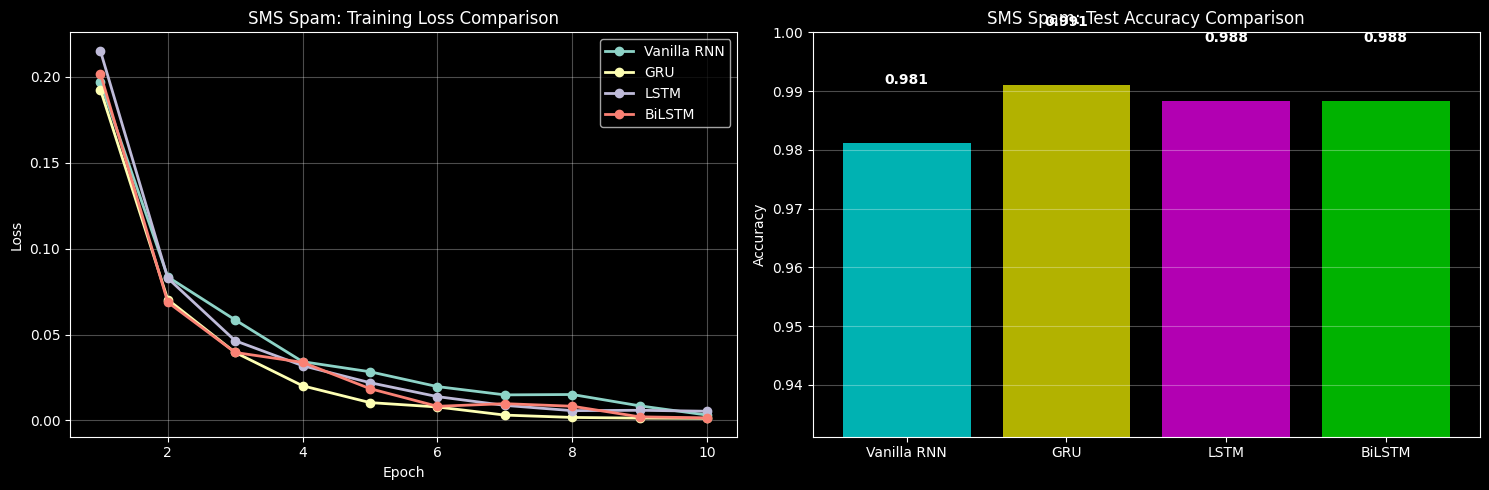

SMS SPAM RESULTS SUMMARY
Vanilla RNN     Accuracy: 0.9812
GRU             Accuracy: 0.9910
LSTM            Accuracy: 0.9883
BiLSTM          Accuracy: 0.9883


In [30]:
# Visualize spam results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training losses
for name, data in spam_results.items():
    ax1.plot(range(1, SPAM_EPOCHS+1), data['losses'], marker='o', label=name, linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('SMS Spam: Training Loss Comparison')
ax1.legend()
ax1.grid(alpha=0.3)

# Test accuracies
models = list(spam_results.keys())
accuracies = [spam_results[m]['accuracy'] for m in models]
colors = ['cyan', 'yellow', 'magenta', 'lime']
ax2.bar(models, accuracies, color=colors, alpha=0.7)
ax2.set_ylabel('Accuracy')
ax2.set_title('SMS Spam: Test Accuracy Comparison')
ax2.set_ylim([min(accuracies) - 0.05, 1.0])
ax2.grid(alpha=0.3, axis='y')
for i, v in enumerate(accuracies):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print('='*60)
print('SMS SPAM RESULTS SUMMARY')
print('='*60)
for name, data in spam_results.items():
    print(f"{name:15s} Accuracy: {data['accuracy']:.4f}")
print('='*60)

---

<div dir="rtl" style="text-align: right; font-size: 24px; font-weight: bold; background: linear-gradient(135deg, #1a1a2e 0%, #16213e 100%); padding: 20px; border-radius: 10px;">

مبروك! خلصت Week 8 بنجاح والحمد لله

</div>


**What We Built This Week:**

1. Many-to-many sequence labeling (Food NER)
2. Many-to-one sequence classification (SMS Spam)
3. 8 total models (4 for each task)
4. Complete training and evaluation pipeline

**Next:** Week 9 covers Attention mechanisms and Transformers!

